In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from parameters import *
# import pandas as pd
# import numpy as np
# import scipy as sci
import scipy.special as sp
# import matplotlib
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm, colors
from scipy import integrate
# from scipy.stats import norm
# import matplotlib.mlab as mlab
# import camb

from lib3 import *
import healpy as hp
from numpy.random import rand
from numba import jit
from datetime import datetime

pl = hp.sphtfunc.pixwin(1024)

white_noise = np.ma.asarray(np.random.normal(0,0.0001, 12*1024**2))
planck_IQU_SMICA= hp.fitsfunc.read_map("./Data SupernovaLBLgov/COM_CMB_IQU-smica_1024_R2.02_full.fits", dtype=np.float)
planck_theory_cl = np.loadtxt("./Data SupernovaLBLgov/COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt")
cl_SMICA = hp.anafast(planck_IQU_SMICA, lmax=1024)
ell = np.arange(len(cl_SMICA))

# Deconvolve the beam and the pixel window function
dl_SMICA = cl_SMICA/(B_l(10.0, ell)**2*pl[0:1025]**2)
dl_SMICA = (ell*(ell+1)* dl_SMICA/(2*math.pi))/1E-12
cl_white = hp.anafast(white_noise, lmax=1024)
dl_white = (ell*(ell+1)* cl_white/(2*math.pi))/1E-12

# plotSMICA_aitoff(planck_IQU_SMICA)
# plotSMICAHistogram(planck_IQU_SMICA)
# plot_WhiteNoise(white_noise)
# plotWhiteNoiseHistogram(white_noise)
# plot_CL(ell, dl_SMICA, planck_theory_cl,dl_white)

# We check the orthogonality of the spherical harmonics:
# Si (l,m) =! (l',m') the inner product must be zero
Y = lambda l, m, theta, phi: sp.sph_harm(m, l, phi, theta)
f = lambda theta, phi: Y(4,3,theta, phi) 
g = lambda theta, phi: Y(4,2,theta, phi) 

# dotprod(f,g)

nside=1024
mm = np.arange(hp.nside2npix(nside))
theta, phi = hp.pix2ang(nside=nside, ipix=mm)

nsidearray=[0] + np.geomspace(1,4000,200)
nsidearray= [int(x) for x in nsidearray]

# @jit(forceobj=True)
def getspectrum(image, nside, nsidearray=[0,1,2,3,4]):
    df=[]
    for l in nsidearray:
        bb=0.0
        thistime=datetime.now()
        for m in np.arange(-l,l+1):
            bb += np.abs(alm(l,m, image))**2
        bb *= 1/(2*l+1)
        cc= [bb,l*(l+1)/(2*np.pi)*np.abs(bb)**2]
        print(l, cc, (datetime.now()-thistime).seconds)
        df.append(cc)
    return pd.DataFrame(df, columns=["cl","pp"])
            
# @jit(forceobj=True)
def alm(l,m, image):
    return np.sum(image*np.sin(theta)*np.conj(Y(l,m,theta, phi)))

def dotprod(f,g):
    #Scipy does not directly integrates complex functions.
    #You have to break them down into two integrals of the real and imaginary part
    integrand_r = lambda theta, phi: np.real(f(theta, phi) * np.conj(g(theta, phi)) * np.sin(theta))
    integrand_i = lambda theta, phi: np.imag(f(theta, phi) * np.conj(g(theta, phi)) * np.sin(theta))
    rr = integrate.dblquad(integrand_r, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)[0]
    ri = integrate.dblquad(integrand_i, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)[0]
    if np.allclose(rr,0):
        rr = 0
    if np.allclose(ri,0):
        ri=0
    return rr + ri*1j

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [1]:
import concurrent.futures
from datetime import datetime
from math import factorial

import matplotlib.pylab as plt
import numpy as np
import bottleneck as bn
import scipy.special as sp
from matplotlib import cm
from scipy.special import eval_gegenbauer
from scipy.special import factorial2 as FF

from parameters import *


class HYPER:
    def __init__(self, nside, kmax, decay_0, decay_k, decay_l, decay_m, thetaphase, sigma_smica, planck_IQU_SMICA,
                 lambda_k=0, lambda_l=0, lambda_m=0):
        self.nside = nside
        self.sigma_smica = sigma_smica
        self.kmax = kmax
        self.decay_0 = decay_0
        self.decay_k = decay_k
        self.decay_l = decay_l
        self.decay_m = decay_m
        self.thetaphase = thetaphase
        self.lambda_k = lambda_k
        self.lambda_l = lambda_l
        self.lambda_m = lambda_m
        self.mm = hp.nside2npix(nside=nside)
        self.df = pd.DataFrame()
        self.SMICA = planck_IQU_SMICA
        self.zeros = np.zeros(self.mm)
        self.twos = self.zeros + 2
        self.ThreeD = self.zeros
        #
        theta, phi = hp.pix2ang(nside=nside, ipix=np.arange(self.mm))
        self.df["theta0"] = theta
        self.df["phi0"] = phi
        self.df["z0"] = np.cos(theta)
        self.df["y0"] = np.sin(theta) * np.sin(phi)
        self.df["x0"] = np.sin(theta) * np.cos(phi)
        self.df["zeros"] = self.zeros
        self.df["twos"] = self.twos
        self.dftotal = np.zeros([1, 5])
        # self.dftotal = np.vstack([self.df[["x0","y0","zeros"]],self.df[["x0","y0","twos"]]])
        # self.dftotal = np.vstack([self.dftotal, self.df[["x0", "zeros","z0"]], self.df[["x0", "twos","z0"]]])
        # self.dftotal = np.vstack([self.dftotal, self.df[["zeros","y0", "z0"]], self.df[["twos","y0", "z0"]]])
        # self.dftotal[:,3] = np.sin(self.dftotal[:,0])
        # self.dftotal[:, 4] = bn.cos(self.dftotal[:, 0])
        self.x = []
        self.df["FourD"] = self.zeros
        self.fcolors = []
        self.population = {}

    def calc_XYZ(self, lambda_k, lambda_l, lambda_m):
        self.lambda_k = lambda_k
        self.lambda_l = lambda_l
        self.lambda_m = lambda_m
        # Calculate ang, ipix
        df1 = np.concatenate([self.df[["x0", "y0", "zeros"]], self.df[["x0", "y0", "twos"]]])
        df1[:, 0] += lambda_k + 1
        df1[:, 1] += lambda_l + 1
        df1[:, 2] += lambda_m + 1
        df1 = np.append(df1,np.expand_dims(hp.ang2pix(nside=1024, phi=df1[:,1], theta=df1[:,2]), axis=1), axis=1)

        df2 = np.concatenate([self.df[["x0", "zeros", "z0"]], self.df[["x0", "twos", "z0"]]])
        df2[:, 0] += lambda_k + 1
        df2[:, 1] += lambda_l + 1
        df2[:, 2] += lambda_m + 1
        df2 = np.append(df2, np.expand_dims(hp.ang2pix(nside=1024, phi=df2[:,0], theta=df2[:,2]), axis=1), axis=1)


        df3 = np.concatenate([self.df[["zeros", "y0", "z0"]], self.df[["twos", "y0", "z0"]]])
        df3[:, 0] += lambda_k + 1
        df3[:, 1] += lambda_l + 1
        df3[:, 2] += lambda_m + 1
        df3 = np.append(df3, np.expand_dims(hp.ang2pix(nside=1024, phi=df3[:,0], theta=df3[:,1]), axis=1), axis=1)

        self.dftotal = pd.DataFrame(np.concatenate([df1,df2,df3]), columns=["x", "y", "z","ipix"])
        self.dftotal["sin"] = np.sin(self.dftotal.x)
        self.dftotal["cos"] = np.cos(self.dftotal.x)
        self.dftotal["FourD"] = 0.0

    def calc3DSphere(self):
        self.fcolors = self.dftotal.groupby("ipix")["FourD"].sum().values

    def calcError(self):
        # # XY Z=0 plane
        #     FourD=0
        #     x, y = [hp.vec2ang([x,y,z]) for x,y,z in zip(self.df.x0,self.df.y0, self.zeros)]
        #     x, y = hp.vec2ang([self.df.x0, self.df.y0, self.zeros])
        #     FourD = self.FourDHypersphericalHarmonic(x,y,self.zeros)
        # # XY Z=1 plane
        #     x, y = [hp.vec2ang([x,y,z]) for x,y,z in zip(self.df.x0, self.df.y0, self.twos)]
        #     FourD += self.FourDHypersphericalHarmonic(x, y, self.twos)
        # # XZ Y=0 plane
        #     x, z = [hp.vec2ang([x,y,z]) for x,y,z in zip(self.df.x0, self.zeros, self.df.z0)]
        #     FourD += self.FourDHypersphericalHarmonic(x, self.zeros, z)
        # # XZ Y=1 plane
        #     x, z = [hp.vec2ang([x, y, z]) for x, y, z in zip(self.df.x0, self.twos, self.df.z0)]
        #     FourD += self.FourDHypersphericalHarmonic(x, self.twos, z)
        # # YZ X=0 plane
        #     y, z = [hp.vec2ang([x,y,z]) for x,y,z in zip(self.zeros, self.df.y0, self.df.z0)]
        #     FourD += self.FourDHypersphericalHarmonic(self.zeros, y, z)
        # # YZ X=1 plane
        #     y, z = [hp.vec2ang([x,y,z]) for x,y,z in zip(self.twos, self.df.y0, self.df.z0)]
        #     FourD += self.FourDHypersphericalHarmonic(self.twos, y, z)
        self.dftotal.FourD = self.FourDHypersphericalHarmonic()
        err = bn.sum(bn.abs((self.dftotal.FourD - self.df["SMICA"]) ** 2))
        return err

    def calc_pop(self, kmax, decay_0, decay_k, decay_l, decay_m, thetaphase, minV):
        mymax = 0.0
        self.population = {}
        self.population[(2, 0, 0)] = 1.0
        self.kmax = kmax
        self.decay_0 = decay_0
        self.decay_k = decay_k
        self.decay_l = decay_l
        self.decay_m = decay_m
        self.thetaphase = thetaphase
        for k in np.arange(1, self.kmax + 1):
            delta_k = 2 * np.pi * k / self.decay_k
            a = np.exp(-k / self.decay_0) / (2 * np.pi) ** 3
            b = np.sin(delta_k + self.thetaphase) / delta_k
            for l in np.arange(1, k + 1):
                delta_l = 2 * np.pi * l / self.decay_l
                c = np.sin(delta_l + self.thetaphase) / delta_l
                for m in np.arange(1, l + 1):
                    delta_m = 2 * np.pi * m / decay_m
                    d = np.sin(delta_m + thetaphase) / delta_m
                    pop = a * b * c * d
                    if pop > mymax:
                        mymax = pop
                    self.population[(k, l, m)] = pop
        deleteme = []
        for key, value in self.population.items():
            self.population[key] = value / mymax
        for key, value in self.population.items():
            if value < minV:
                deleteme.append(key)
        print(len(self.population))
        [self.population.pop(x) for x in deleteme]
        print(len(self.population))

    def plot_aitoff(self):
        fig = plt.figure(1, figsize=[12, 12])
        hp.mollview(self.fcolors, min=-0.0007, max=0.0007, title="Planck Temperature Map", fig=1, unit="K",
                    cmap=cm.RdBu_r)
        hp.graticule()
        plt.savefig(imgAddress + "aitoff_kmax_{}.png".format(self.kmax), dpi=300)
        plt.show()

    def plotHistogram(self):
        (mu, sigma) = norm.fit(bn.abs(self.fcolors))
        fig, ax = plt.subplots()
        n, bins, patch = plt.hist(bn.abs(self.fcolors), 600, density=1, facecolor="r", alpha=0.25)
        y = norm.pdf(bins, mu, sigma)
        plt.plot(bins, y)
        plt.xlim(mu - 5 * sigma, mu + 5 * sigma)
        plt.xlabel("Temperature/K")
        plt.ylabel("Frequency")
        plt.title(r"Histogram of $12-N_{side}^2$ pixels from the Planck SMICA Map ", y=1.08)
        plt.savefig(imgAddress + "Histogram_kmax_{}.png".format(self.kmax), dpi=300)
        plt.show()

    def normalizeFColors(self):
        (mu, sigma) = norm.fit(bn.abs(self.fcolors))
        self.fcolors = self.sigma_smica / sigma * (self.fcolors - mu)

    def hyperharm(self, prime):
        k = prime[0]
        l = prime[1]
        m = prime[2]
        print(k, l, m)
        N = (-1) ** k * 1j ** l * FF(2 * l) * np.sqrt(2 * (k + 1) * factorial(k - l) / np.pi / factorial(k + l + 1))
        a = self.dftotal.sin ** l
        b = sp.sph_harm(m, l, self.dftotal.y, self.dftotal.z)
        c = eval_gegenbauer(1 + l, k - l, self.dftotal.cos)
        # self.dftotal.FourD += self.population[(k, l, m)] * N * a * b * c
        return self.population[(k, l, m)] * N * a * b * c

    def FourDHypersphericalHarmonic(self):
        self.dftotal.FourD=0.0
        fcolors = self.dftotal.FourD
        # for kkk in self.population.keys():
        #     fcolors += self.hyperharm(kkk)
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for kkk, prime in zip(self.population.keys(), executor.map(self.hyperharm,self.population.keys())):
                fcolors += prime
        return fcolors




NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/mp74207/anaconda3/envs/Cosmo36/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


In [2]:
nside = 1024
thetaphase = 0.3
kmax = 3
decay_0 = 10000
decay_k = 0.03
decay_l = 0.02
decay_m = 0.01
lambda_k = 0
lambda_l = 0
lambda_m = 0
minV = 1E-5

myHyper = HYPER(nside, kmax, decay_0, decay_k, decay_l, decay_m,
                thetaphase, sigma_smica, planck_IQU_SMICA, lambda_k, lambda_l, lambda_m)

# myHyper.LM_Decomposition()
lenPop = myHyper.calc_pop(kmax, decay_0, decay_k, decay_l, decay_m, thetaphase, minV)
myHyper.calc_XYZ(lambda_k, lambda_l, lambda_m)
# print(lenPop)
thistime = datetime.now()
myHyper.dftotal.FourD = myHyper.FourDHypersphericalHarmonic()
print((datetime.now() - thistime).seconds)
# myHyper.normalizeFColors()
# myHyper.plot_aitoff()
# myHyper.plotHistogram()

11
8


KeyError: 'Column not found: FourD'

In [ ]:
df1=df1[0:10].groupby("ipix")["FourD"].sum()

In [19]:
df1

ipix
2890866    1.681182e+1j
2890867    8.405912e+1j
2890868    8.405912e+1j
2890869    1.681182e+1j
2890870    8.405912e+1j
2890871    8.405912e+1j
2890872    1.681182e+1j
Name: FourD, dtype: complex128

In [ ]:
ind2 = (myHyper.dftotal.y == 0) | (myHyper.dftotal.y == 1)
df2=myHyper.dftotal[ind2].groupby(by=["x","z"]).FourD.sum()
ind3 = (myHyper.dftotal.z == 0) | (myHyper.dftotal.z == 1)
df3=myHyper.dftotal[ind3].groupby(by=["x","y"]).FourD.sum()

In [20]:
myHyper.normalizeFColors()
myHyper.plot_aitoff()
myHyper.plotHistogram()

TypeError: bad number of pixels

<Figure size 864x864 with 0 Axes>

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


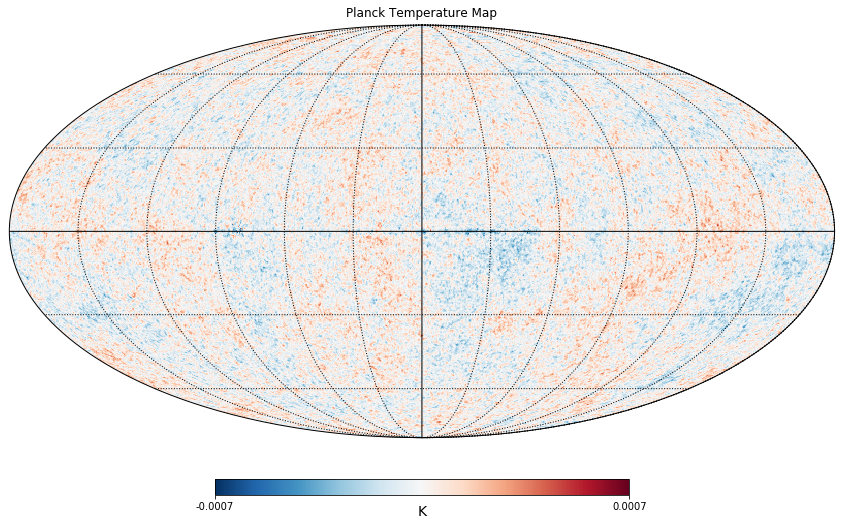

In [21]:
fig=plotSMICA_aitoff(planck_IQU_SMICA)

In [6]:
# alm(4,2,planck_IQU_SMICA,1024)
image=planck_IQU_SMICA
nside=1024

getspectrum(image, nside)


# l=4
# m=4
# alm(l,m, image)
# # getspectrum(image, nside, lmax=10)

# df = []
# for l in np.arange(1):
#     aa=0
#     for m in np.arange(-l-1,l+1):
#         a= alm(l,m, image)
#         aa += a*np.conj(a)
#     df.loc[l,"cl"]*=1/(2*l+1)
#     df.loc[l,"pp"]*=l*(l+1)/(2*np.pi)*df.loc[l,"cl"]*df.loc[l,"cl"]

0 [10.33592512610772, 0.0] 0
1 [1.1892030385398924, 0.4501550719048662] 4
2 [135.43024676462906, 17514.70075323445] 8
3 [427.5416275981413, 349106.70507278707] 13
4 [127.67777088113439, 51889.646350389005] 19


,cl,pp
0,10.335925,0.000000
1,1.189203,0.450155
2,135.430247,17514.700753
3,427.541628,349106.705073
4,127.677771,51889.646350


In [7]:
l=4
m=-4
alm(l,m, image)

(-3.565123309185635+8.528866208745384j)

In [8]:
# We check the orthogonality of the spherical harmonics:
# Si (l,m) =! (l',m') the inner product must be zero
theta,phi, x,y,z = getSphericalXYZ()
fcolors = np.cos(2*theta+phi)
phi0=0.5
theta0=0.2
Y = lambda l, m, theta, phi: sp.sph_harm(m, l, phi, theta)
f = lambda theta, phi: Y(4,3,theta+theta0, phi+phi0) 
g = lambda theta, phi: Y(4,2,theta+theta0, phi+phi0) 
# dotprod(f,g)

1 0 2.665204802077258 1.5622317546700188 0.3129950441365672
2 0 3.0443124221030993 1.92197524841137 0.9864764100777216
2 1 0.7368715513173127 0.6753117738953154 0.19896353140909406
3 0 1.3277587773405712 0.6423426061542975 0.48664790319054285
3 1 3.107218811656781 0.5117679183258035 0.7543191803568867
3 2 2.7833501377109116 1.182833790864911 0.5274381923813655
4 0 1.9570683449798074 2.77238571849922 0.3573119605406887
4 1 2.081216524959838 1.754235248662304 0.47948363148238904
4 2 1.2792665856982548 0.7856838914330012 0.370444218597639
4 3 1.448678525653407 1.885961659974565 0.7923624655474985
5 0 1.7766008080632318 0.7910041942041873 0.4741453555262196
5 1 2.8174763872094446 0.5240001930040653 0.5605202022553283
5 2 1.1340161703817364 1.7616323105561604 0.8546580967402716
5 3 1.326379640839993 0.3378365934094448 0.2330127039974884
5 4 0.6464900987002269 1.6864297127441004 0.14369842156296175
6 0 2.9574649319971384 2.3430188553750675 0.862916353698488
6 1 2.4893104032145956 2.192792427

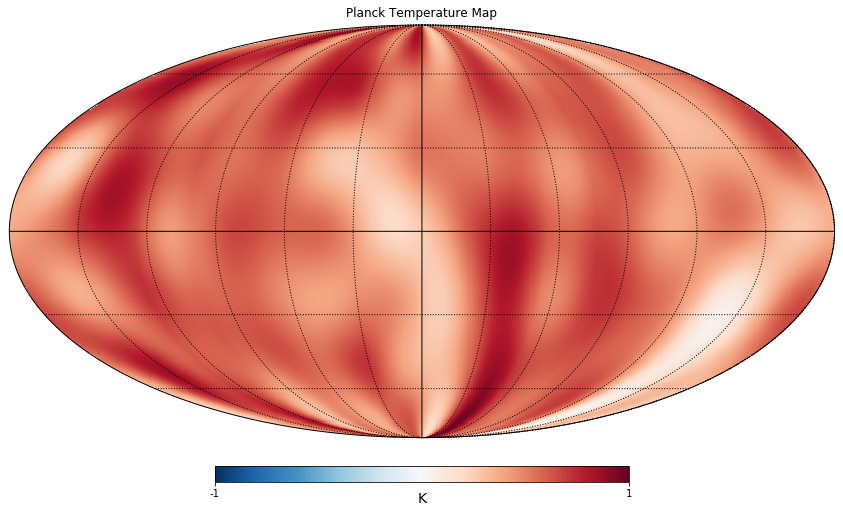

In [10]:

# Number of sample points
N = 1000
a1=1.8
a2=3.5
a3=-0.6
phase0=0.25
nx=120
ny=100
nz=140

from numba import jit

@jit(forceobj=True)
def createSphere(nside,cl_map):
    # sample spacing
    theta, phi = getSphericalXYZ(nside=nside)
    fcolors=np.zeros(len(theta))
    for l, m, a_theta, a_phi, ampl in cl_map:
        print (l, m, a_theta, a_phi, ampl)
        fcolors += ampl*norm_harmonic(l,m, theta-a_theta, phi - a_phi)
    fmin=np.min(fcolors)
    fmax=np.max(fcolors)
    fcolors = (fcolors-fmin)/(fmax-fmin)
    return fcolors, fmin, fmax

def getSphericalXYZ(nside=10, cl_map=[]):
    m = np.arange(hp.nside2npix(nside))
    theta, phi = hp.pix2ang(nside=nside, ipix=m)
    return theta, phi



cl_map=[]
for l in range(10):
    for m in range(l):
        ampl=rand()
        a_theta=rand()*np.pi
        a_phi = rand()*np.pi
        cl_map.append([l,m,a_theta, a_phi, ampl])
        

nside=1024
fcolors, fmin, fmax =createSphere(nside=nside, cl_map=cl_map)
# theta, phi= hp.pix2ang(nside=nside)

fig = plt.figure(figsize=(12, 8))
# fig.add_subplot(111, projection='aitoff')

# fig = plt.figure(1, figsize=[12,12])
hp.mollview(fcolors, min=-1, max=+1,title="Planck Temperature Map", fig=1, unit="K", cmap=cm.RdBu_r)
hp.graticule()
# plt.show()


# plt.xlabel('R.A.')
# plt.ylabel('Decl.')
# plt.grid(True)
# plt.colorbar(fcolors, spacing='uniform', extend='max')
# plt.savefig(imgAddress + "G_Decay{}.png".format(nside), dpi=300)
plt.show()

$$ {e^{i{k_n} \cdot x}} = \sum\nolimits_{l = 0}^\infty  {4\pi \sum\limits_{m =  - l}^l {{i^l}{j_l}({k_n}r)Y_{lm}^*(\vartheta ,\varphi ){Y_{lm}}(\theta ,\phi )} }  = \sum\nolimits_{l = 0}^\infty  {\sum\limits_{m =  - l}^l {{j_l}((2\pi  + \delta )n){a_{lm}}(\vartheta ,\varphi ){Y_{lm}}(\theta ,\phi )} } $$

$$ {a_{lm}} = 4\pi {i^l}Y_{lm}^*(\vartheta ,\varphi ) $$

$$ f(x) = \sum\limits_{i = 0}^\infty  {{b_n}} {e^{i{k_n} \cdot x}} = \sum\nolimits_{l = 0}^\infty  {\sum\limits_{m =  - l}^l {\frac{1}{{\sqrt {2\pi } }}\sum\limits_{n = 0}^\infty  {{b_n}{j_l}((2\pi  + \delta )n){a_{lm,n}}(\vartheta ,\varphi ){Y_{lm}}(\theta ,\phi )} } }  $$
$$ f(x) = \sum\limits_{l = 0}^\infty  {\sum\limits_{m =  - l}^l {{c_{lm}}{Y_{lm}}(\theta ,\phi )} }  $$
$$ {c_{lm}} = \frac{{{a_{lm}}(\vartheta ,\varphi )}}{{\sqrt {2\pi } }}\sum\limits_{n = 0}^\infty  {{b_n}{j_l}((2\pi  + \delta )n)}  $$

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


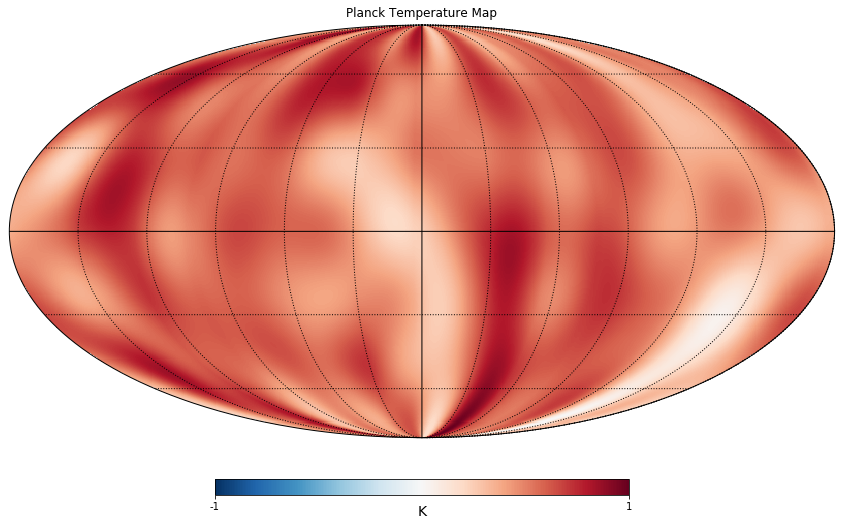

In [13]:
NSIDE = 10
fig = plt.figure(1, figsize=[12,12])
hp.mollview(fcolors, min=-1, max=+1,title="Planck Temperature Map", fig=1, unit="K", cmap=cm.RdBu_r)
hp.graticule()
plt.show()

In [14]:
fmap= hp.anafast(fcolors, lmax=10)

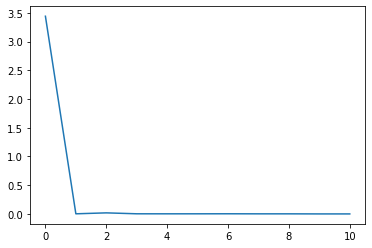

In [15]:
plt.plot(fmap)

In [60]:
import numpy as np
import healpy as hp
nside = 2 # healpix nside parameter
m = np.arange(hp.nside2npix(nside)) # create a map to test
alm = hp.map2alm(m) # compute alm's
new_map = hp.alm2map(alm, nside) # create new map from computed alm's

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [4]:
theta, phi, x, y, z = getSphericalXYZ()
fig.savefig("./img/SMICAaitoff.png")

In [2]:
# hp.xyf2pix()
# from astropy_healpix import HEALPix
# hp = HEALPix(nside=16, order='nested')
# lon, lat = hp.healpix_to_lonlat([1, 442, 2200])
# hp.lonlat_to_healpix(lon,lat)

In [16]:
import pandas as pd
import healpy as hp
import numpy as np

df = pd.DataFrame()
theta, phi = hp.pix2ang(nside=nside, ipix=mm)
df["theta0"]=theta
df["phi0"]=phi
df["z0"]= np.cos(theta)
df["y0"]= np.sin(theta)*np.sin(phi)
df["x0"]=np.sin(theta)*np.cos(phi)